# **Đường dẫn thư mục chứa dữ liệu**

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
folder = "/content/drive/MyDrive/Năm 3/01. Data Mining/KPDL - Đồ án cuối kỳ"

# **Thư viện**

In [ ]:
!pip install pyECLAT

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyECLAT import ECLAT
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import time
import warnings

warnings.filterwarnings("ignore")

# **1. Tiền xử lý & EDA**

## **1.1 Kiểm tra sơ bộ & Tiền xử lý**

In [ ]:
df = pd.read_csv(folder + "/Groceries 3.csv", index_col=0)
df.tail()

,Apple,Bread,Butter,Cheese,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Sugar,Unicorn,Yogurt,Chocolate
994,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True
995,True,False,False,False,True,False,False,False,True,True,True,False,False,False,True,False
996,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,True
997,False,False,True,True,True,False,True,True,True,False,True,False,True,False,True,True
998,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Apple         999 non-null    bool 
 1   Bread         999 non-null    bool 
 2   Butter        999 non-null    bool 
 3   Cheese        999 non-null    bool 
 4   Corn          999 non-null    bool 
 5   Dill          999 non-null    bool 
 6   Eggs          999 non-null    bool 
 7   Ice cream     999 non-null    bool 
 8   Kidney Beans  999 non-null    bool 
 9   Milk          999 non-null    bool 
 10  Nutmeg        999 non-null    bool 
 11  Onion         999 non-null    bool 
 12  Sugar         999 non-null    bool 
 13  Unicorn       999 non-null    bool 
 14  Yogurt        999 non-null    bool 
 15  Chocolate     999 non-null    bool 
dtypes: bool(16)
memory usage: 23.4 KB


> Từ kết quả trên có thể thấy:
- Bộ dữ liệu có 999 dòng (mỗi dòng là một giao dịch) và 16 cột (16 items)
- Không có cột nào có giá trị bị thiếu
- Tất cả các cột đều có kiểu dữ liệu ***bool***

## **1.2 EDA (Explanatory Data Analysis)**

In [ ]:
df.describe()

,Apple,Bread,Butter,Cheese,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Sugar,Unicorn,Yogurt,Chocolate
count,999,999,999,999,999,999,999,999,999,999,999,999,999,999,999,999
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,616,615,579,595,592,601,615,589,591,594,598,596,590,610,579,578


> Vì là biến boolean nên số giá trị unique của tất cả các cột đều bằng 2: True và False
>
> Giá trị False nhiều hơn giá trị True ở tất cả các cột


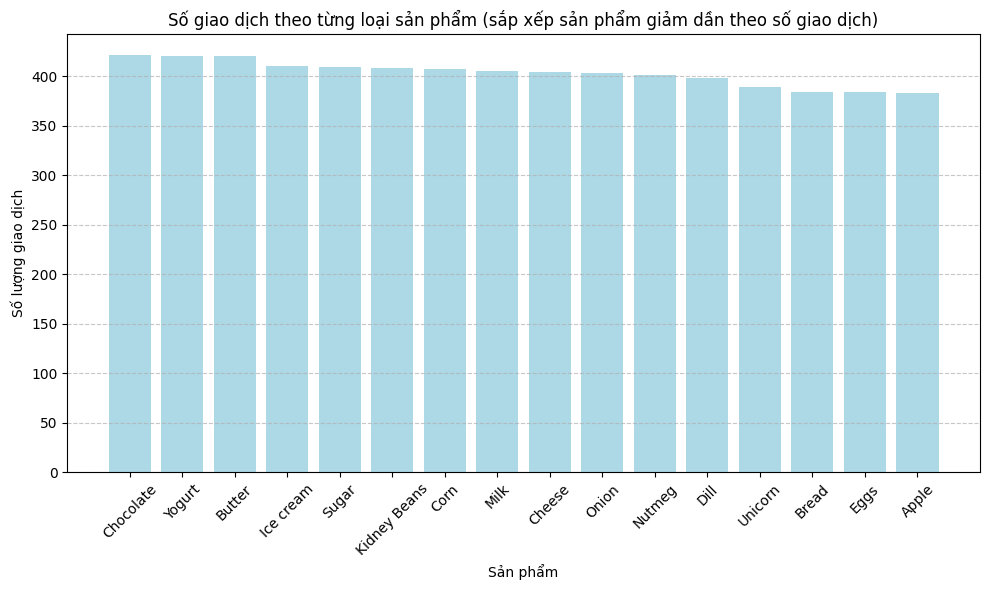

In [ ]:
vertical_dict = {}

for index, row in df.iterrows():
    for col in df.columns:
        if row[col] == True:
            if col not in vertical_dict:
                vertical_dict[col] = []
            vertical_dict[col].append(str(index))

vertical_df = pd.DataFrame(list(vertical_dict.items()), columns=['Item', 'Transactions'])

# vertical_df.sort_values(by='Item', inplace=True)
# vertical_df.reset_index(drop=True, inplace=True)

vertical_df['Transaction Count'] = vertical_df['Transactions'].str.len()
vertical_df.sort_values(by='Transaction Count', ascending=False, inplace=True)
vertical_df.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10, 6))
plt.bar(vertical_df['Item'], vertical_df['Transaction Count'], color='lightblue')
plt.xlabel("Sản phẩm")
plt.ylabel("Số lượng giao dịch")
plt.title("Số giao dịch theo từng loại sản phẩm (sắp xếp sản phẩm giảm dần theo số giao dịch)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

> Các sản phẩm có số lần xuất hiện gần như tương đồng nhau

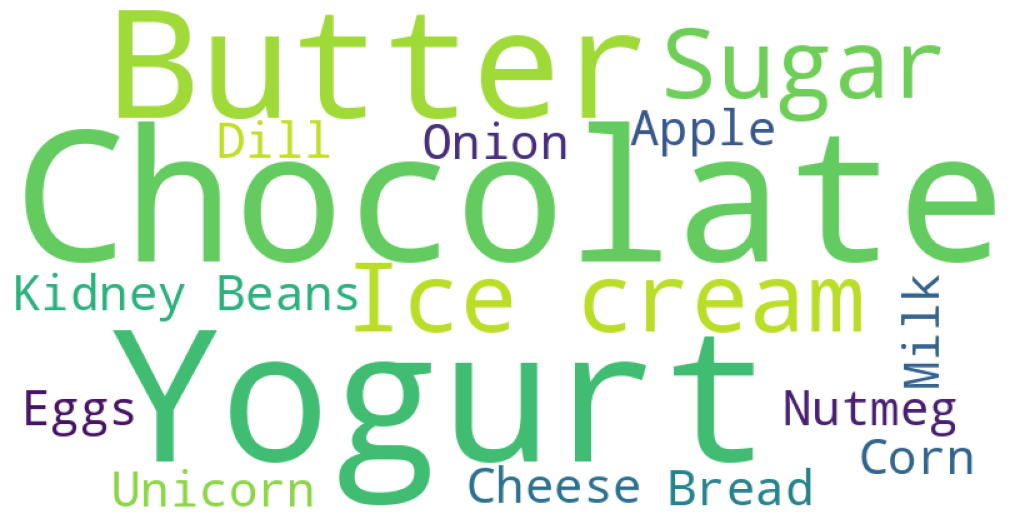

In [ ]:
item_counts = dict(zip(vertical_df['Item'], vertical_df['Transaction Count']))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(item_counts)

plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
df_describe = pd.DataFrame(vertical_df["Transaction Count"].describe()).T
df_describe.insert(1, "median", vertical_df["Transaction Count"].median())
df_describe.insert(2, "mode", vertical_df["Transaction Count"].mode().iloc[0])
df_describe.insert(3, "range", vertical_df["Transaction Count"].max() - vertical_df["Transaction Count"].min())
df_describe

,count,median,mode,range,mean,std,min,25%,50%,75%,max
Transaction Count,16.0,404.5,384,38,402.875,12.595634,383.0,395.75,404.5,409.25,421.0


> Theo thống kê mô tả trên, ta thấy khoảng giá trị dao động (range) của số giao dịch của mỗi mặt hàng là 38.
>
> Một mặt hàng xuất hiện trong khoảng 383 đến 421 giao dịch trên tổng cộng 999 giao dịch
>
> Các mặt hàng xuất hiện trong khoảng 38-42% giao dịch, phần trăm này khá cao. Vậy nên, ma trận giao dịch không phải là ma trận thưa. Trong ma trận thưa, tần suất xuất hiện của một phần tử hoặc một mục thường rất thấp (thường dưới 5%)

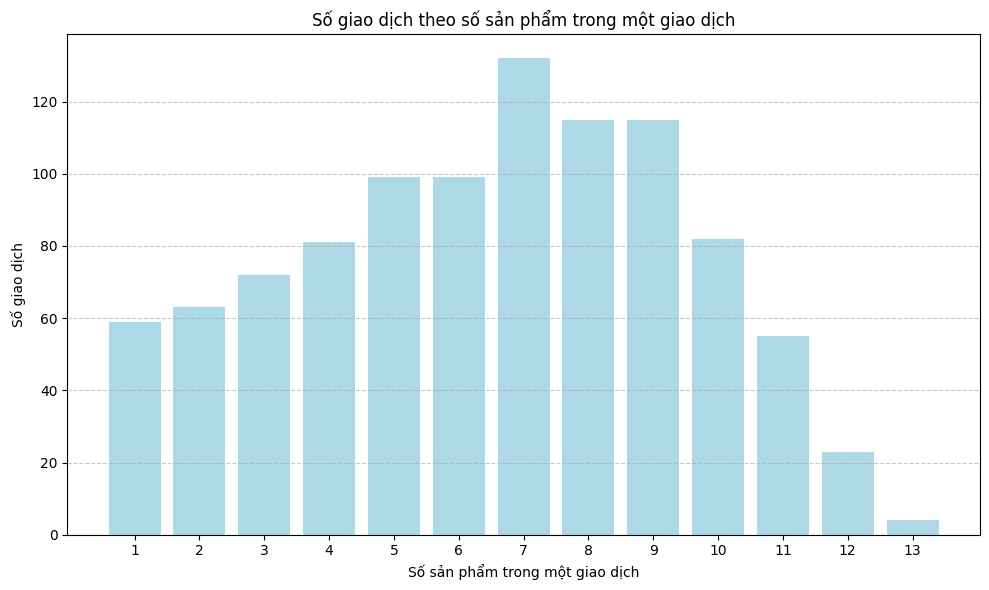

In [ ]:
transactions = []
for index, row in df.iterrows():
    items = []
    for col in df.columns:
        if row[col] == True:
            items.append(col)
    transactions.append(items)

items_df = pd.DataFrame({'ID': df.index, 'Items': transactions})
items_per_transaction = items_df['Items'].str.len()
plot_df = pd.DataFrame({'Transaction ID': items_df['ID'], 'Number of Items': items_per_transaction})
plot_df = plot_df.sort_values(by='Number of Items', ascending=False)
transaction_counts = plot_df['Number of Items'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(transaction_counts.index, transaction_counts.values, color='lightblue')
plt.xlabel("Số sản phẩm trong một giao dịch")
plt.ylabel("Số giao dịch")
plt.title("Số giao dịch theo số sản phẩm trong một giao dịch")
plt.xticks(np.arange(1, 14), rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

>
>
> Các giao dịch mua 7 sản phẩm cao nhất, kế đến 8 và 9 sản phẩm
>
> Từ 11 sản phẩm trở đi, số giao dịch giảm và thấp nhất ở số sản phẩm là 13, không có giao dịch chứa 14 sản phẩm trở lên

# **2. Tìm các tập mục phổ biến (Frequent Itemsets)**

## **Chọn ngưỡng min support phù hợp**

In [ ]:
def calculate_min_sup_for_pairs(transactions, target_ratio=0.1):
    """
    Tìm min_sup sao cho các tập mục có 2 phần tử xuất hiện nhiều hơn.

    Args:
        transactions (list of list): Tập dữ liệu giao dịch.
        target_ratio (float): Tỷ lệ mục tiêu các tập 2 phần tử so với tổng giao dịch.

    Returns:
        float: Giá trị min_sup phù hợp.
    """
    num_transactions = len(transactions)

    # Đếm tần số xuất hiện của từng cặp mục
    pair_counts = Counter()
    for transaction in transactions:
        for pair in combinations(sorted(transaction), 2):
            pair_counts[pair] += 1

    # Tính support cho từng cặp
    pair_supports = [count / num_transactions for count in pair_counts.values()]

    # Tính trung bình và chọn ngưỡng dựa trên target_ratio
    avg_pair_support = np.mean(pair_supports)
    min_sup = avg_pair_support * target_ratio

    print(f"Tổng số giao dịch: {num_transactions}")
    print(f"Số cặp sản phẩm: {len(pair_counts)}")
    print(f"Support trung bình của cặp sản phẩm: {avg_pair_support:.4f}")
    print(f"Min Support được chọn: {min_sup:.4f}")

    return min_sup

min_sup = round(calculate_min_sup_for_pairs(transactions, target_ratio=0.6), 2)
print(f"Min Support cuối cùng: {min_sup}")

Tổng số giao dịch: 999
Số cặp sản phẩm: 120
Support trung bình của cặp sản phẩm: 0.1828
Min Support được chọn: 0.1097
Min Support cuối cùng: 0.11


## **2.1 Cài đặt thuật toán ECLAT**

**Pseudocode:** (nguồn: https://www.philippe-fournier-viger.com/COURSES/Pattern_mining/Eclat.pdf)

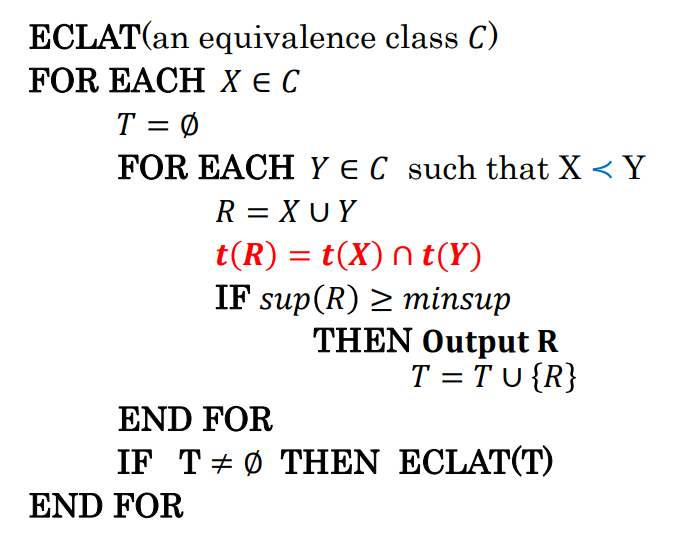

In [ ]:
class FrequentItemsetsMining:
    def __init__(self, transaction_data, min_support):
        self.transaction_data = transaction_data
        self.num_of_transactions = len(transaction_data)
        self.min_support = min_support
        # Chuyển từ min_sup sang min_freq, làm tròn lên
        self.min_freq = np.ceil(min_support * self.num_of_transactions)
        self.vertical_data = self.create_vertical_data()

    def create_vertical_data(self):
        """
        Biểu diễn dữ liệu theo chiều dọc cho thuật toán ECLAT:
        Trong định dạng này, mỗi sản phẩm sẽ được liên kết với một danh sách
        bao gồm các ID (hoặc số thứ tự) của giao dịch mà sản phẩm đó đã xuất hiện.
        """
        vertical_data = {}
        for tid, transaction in enumerate(self.transaction_data):
            for item in transaction:
                if item not in vertical_data:
                    vertical_data[item] = set()
                vertical_data[item].add(tid)
        return vertical_data

    def intersect(self, tids1, tids2):
        return tids1.intersection(tids2)

    def eclat(self, equivalence_class, prefix=frozenset()):
        """
        Thuật toán ECLAT để tìm tập mục phổ biến.

        Parameters:
            - equivalence_class: Dictionary với key là item và value là tập giao dịch chứa item.
            - prefix: frozenset đại diện cho tập mục hiện tại trong đệ quy.

        Returns:
            - result: Danh sách các tuple (frozenset itemset, frequency).
        """
        result = []
        for i, (item, tids) in enumerate(equivalence_class.items()):
            freq = len(tids)
            if freq >= self.min_freq:
                # Tạo tập mục phổ biến dưới dạng frozenset
                frequent_itemset = prefix | frozenset([item])
                result.append((frequent_itemset, freq))

                # Tạo lớp tương đương (equivalence class) mới
                suffix_class = {}
                for next_item, next_tids in list(equivalence_class.items())[i + 1:]:
                    intersect_tids = self.intersect(tids, next_tids)
                    if len(intersect_tids) >= self.min_freq:
                        suffix_class[next_item] = intersect_tids

                # Đệ quy trên lớp tương đương mới
                result.extend(self.eclat(suffix_class, frequent_itemset))
        return result

    def itemsets_list_to_df(self, frequent_itemsets):
        # Kết quả được sắp xếp theo support
        frequent_itemsets.sort(key=lambda x: x[1])
        frequent_itemsets_df = pd.DataFrame(frequent_itemsets, columns=['Itemset', 'Frequency'])
        frequent_itemsets_df['Support'] = frequent_itemsets_df['Frequency'] / miner.num_of_transactions

        return frequent_itemsets_df

    def is_covering(self, itemset1, itemset2):
        """
        Kiểm tra xem itemset1 có bao phủ itemset2 không.

        Parameters:
            - itemset1: Tập item (frozenset).
            - itemset2: Tập item (frozenset).

        Returns:
            - True nếu itemset1 bao phủ itemset2, ngược lại False.
        """
        return set(itemset2).issubset(set(itemset1))

    def find_maximal_covering_itemsets(self, frequent_itemsets_df):
        """
        Tìm các itemsets lớn nhất bao phủ các itemset còn lại.

        Parameters:
            - frequent_itemsets_df: DataFrame chứa các cột 'Itemset' và 'Support'.

        Returns:
            - DataFrame chỉ chứa các itemsets lớn nhất.
        """
        # Lấy danh sách itemsets từ DataFrame
        itemsets = frequent_itemsets_df['Itemset'].tolist()

        # Lưu trữ các itemsets không bị bao phủ bởi bất kỳ itemset lớn hơn nào
        maximal_itemsets = []

        for i, itemset1 in enumerate(itemsets):
            is_maximal = True
            for j, itemset2 in enumerate(itemsets):
                if i != j and self.is_covering(itemset2, itemset1) and len(itemset2) > len(itemset1):
                    is_maximal = False
                    break
            if is_maximal:
                maximal_itemsets.append(itemset1)

        # Tạo DataFrame chỉ chứa các itemsets lớn nhất
        return frequent_itemsets_df[frequent_itemsets_df['Itemset'].isin(maximal_itemsets)]


In [ ]:
transactions = items_df['Items'].to_list()

min_support = min_sup
miner = FrequentItemsetsMining(transactions, min_support)

equivalence_class = miner.vertical_data # Scan database 1 lần để tạo vertical format data
frequent_itemsets = miner.eclat(equivalence_class)

print("Min support:", min_support)
print("Số tập mục phổ biến:", len(frequent_itemsets))
print()

frequent_itemsets_df = miner.itemsets_list_to_df(frequent_itemsets)
frequent_itemsets_df

Min support: 0.11
Số tập mục phổ biến: 138



,Itemset,Frequency,Support
0,"(Ice cream, Kidney Beans, Butter)",110,0.110110
1,"(Milk, Chocolate, Dill)",114,0.114114
2,"(Apple, Bread)",154,0.154154
3,"(Apple, Eggs)",156,0.156156
4,"(Eggs, Bread)",157,0.157157
...,...,...,...
133,(Sugar),409,0.409409
134,(Ice cream),410,0.410410
135,(Yogurt),420,0.420420
136,(Butter),420,0.420420


**Tìm các tập mục phổ biến bao phủ các tập mục phổ biến con còn lại**

In [ ]:
covering_itemsets_df = miner.find_maximal_covering_itemsets(frequent_itemsets_df)
# covering_itemsets_df.to_csv(folder + '/covering_itemsets_df.csv', index=False)
covering_itemsets_df

,Itemset,Frequency,Support
0,"(Ice cream, Kidney Beans, Butter)",110,0.110110
1,"(Milk, Chocolate, Dill)",114,0.114114
2,"(Apple, Bread)",154,0.154154
3,"(Apple, Eggs)",156,0.156156
4,"(Eggs, Bread)",157,0.157157
...,...,...,...
113,"(Nutmeg, Butter)",198,0.198198
115,"(Kidney Beans, Milk)",199,0.199199
116,"(Cheese, Kidney Beans)",200,0.200200
117,"(Ice cream, Chocolate)",202,0.202202


**Số tập mục phổ biến và thời gian chạy trung bình theo Min Support**

In [ ]:
min_support_range = np.arange(0.03, 0.51, 0.01)
num_list = []

for min_support in min_support_range:
    miner = FrequentItemsetsMining(transactions, min_support)

    equivalence_class = miner.vertical_data
    frequent_patterns = miner.eclat(equivalence_class)

    num_list.append(len(frequent_patterns))

In [ ]:
time_list = []
average_time = []

n = 100  # số lần chạy

for min_support in min_support_range:
    total_time = 0
    for i in range(n):
        miner = FrequentItemsetsMining(transactions, min_support)

        start_time = time.time()
        equivalence_class = miner.vertical_data
        frequent_patterns = miner.eclat(equivalence_class)
        end_time = time.time()

        total_time += (end_time - start_time)

    # Tính trung bình thời gian cho n lần chạy
    average_time.append(total_time / n)

print("Số tập mục phổ biến cho mỗi giá trị min_support:", num_list)
print("Thời gian chạy trung bình cho mỗi giá trị min_support:", average_time)

Số tập mục phổ biến cho mỗi giá trị min_support: [2617, 2058, 947, 698, 685, 615, 391, 169, 138, 136, 136, 136, 136, 131, 120, 94, 53, 22, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 11, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0]
Thời gian chạy trung bình cho mỗi giá trị min_support: [0.14365415573120116, 0.07067057371139526, 0.028612301349639893, 0.03470980167388916, 0.0255195689201355, 0.021299865245819092, 0.014892604351043701, 0.010973358154296875, 0.010732567310333252, 0.01086153745651245, 0.012397055625915527, 0.01430769681930542, 0.014360876083374023, 0.012821955680847168, 0.009307992458343507, 0.007237248420715332, 0.003987607955932618, 0.0030766582489013673, 0.0030237531661987307, 0.002952878475189209, 0.003046865463256836, 0.0029684972763061525, 0.003027827739715576, 0.003016524314880371, 0.0029576492309570314, 0.003034543991088867, 0.002969508171081543, 0.003006300926208496, 0.0030374765396118165, 0.002963895797729492, 0.0030559873580932617, 0.002951273918

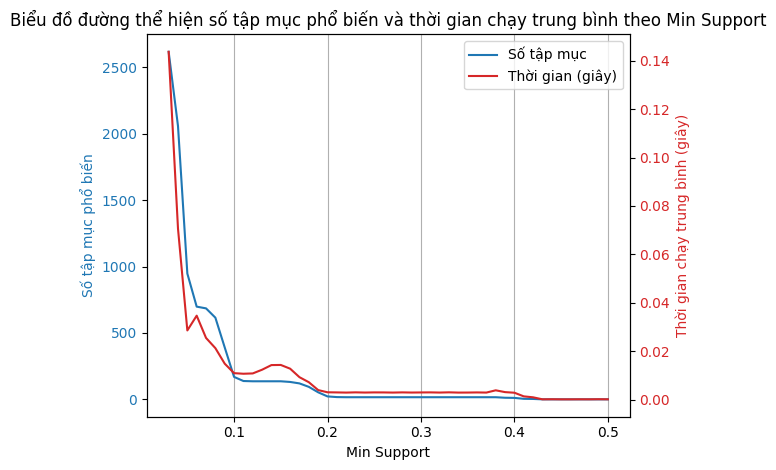

In [ ]:
fig, ax1 = plt.subplots()

color1 = 'tab:blue'
ax1.set_xlabel('Min Support')
ax1.set_ylabel('Số tập mục phổ biến', color=color1)
ax1.plot(min_support_range, num_list, color=color1, label='Số tập mục')
ax1.tick_params(axis='y', labelcolor=color1)
ax1. grid(axis='x')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Thời gian chạy trung bình (giây)', color=color2)
ax2.plot(min_support_range, average_time, color=color2, label='Thời gian (giây)')
ax2.tick_params(axis='y', labelcolor=color2)

fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.title('Biểu đồ đường thể hiện số tập mục phổ biến và thời gian chạy trung bình theo Min Support')
plt.tight_layout()
plt.show()

> Nên chọn ngưỡng min_sup từ 0.1 đến 0.2 đối với tập dữ liệu này

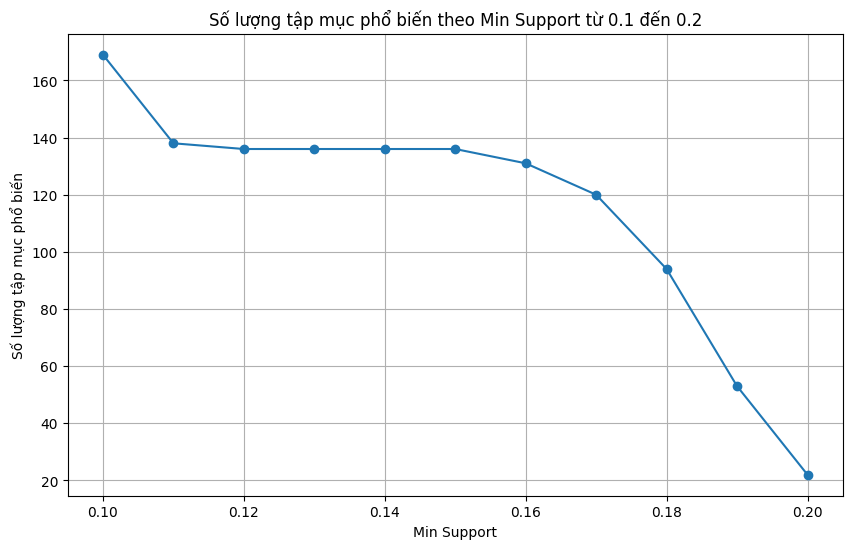

In [ ]:
min_support_range = np.arange(0.1, 0.21, 0.01)
num_list = []

for min_support in min_support_range:
    miner = FrequentItemsetsMining(transactions, min_support)

    equivalence_class = miner.vertical_data
    frequent_patterns = miner.eclat(equivalence_class)

    num_list.append(len(frequent_patterns))

plt.figure(figsize=(10, 6))
plt.plot(min_support_range, num_list, marker='o', linestyle='-')
plt.xlabel('Min Support')
plt.ylabel('Số lượng tập mục phổ biến')
plt.title('Số lượng tập mục phổ biến theo Min Support từ 0.1 đến 0.2')
plt.grid(True)
plt.show()

In [ ]:
num_list

[169, 138, 136, 136, 136, 136, 131, 120, 94, 53, 22]

> Từ số tập mục phổ biến ở ngưỡng min_sup = 0.1 là gần 170 itemset sang ngưỡng min_sup = 0.11 giảm còn 138 itemset
>
> Chọn min_sup = 0.11

In [ ]:
min_sup = 0.11

## **2.2 Cài đặt các thuật toán bằng thư viện có sẵn**

## **2.2.1 ECLAT - dùng thư viện pyECLAT**

> https://pypi.org/project/pyECLAT/
>

In [ ]:
# Đổi sang định dạng mỗi dòng là một giao dịch của khách hàng
transactions = []
for index, row in df.iterrows():
    items = []
    for col in df.columns:
        if row[col] == True:
            items.append(col)
    transactions.append(items)

df1 = pd.DataFrame(transactions)
df1 = df1.replace({None: np.nan})
df1.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12
994,Bread,Eggs,Unicorn,Chocolate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
995,Apple,Corn,Kidney Beans,Milk,Nutmeg,Yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,Apple,Corn,Dill,Sugar,Chocolate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,Butter,Cheese,Corn,Eggs,Ice cream,Kidney Beans,Nutmeg,Sugar,Yogurt,Chocolate,NaN,NaN,NaN
998,Milk,Chocolate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
eclat_instance = ECLAT(data=df1, verbose=True)

100%|██████████| 16/16 [00:00<00:00, 1383.17it/s]


In [ ]:
eclat_instance.df_bin.head()

,Chocolate,Corn,Ice cream,Cheese,Dill,Sugar,Nutmeg,Kidney Beans,Yogurt,Apple,Butter,Unicorn,Eggs,Onion,Bread,Milk
0,1,1,1,0,1,1,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,1
3,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
print("Danh sách giá trị không trùng lặp:", eclat_instance.uniq_)

Danh sách giá trị không trùng lặp: ['Chocolate', 'Corn', 'Ice cream', 'Cheese', 'Dill', 'Sugar', 'Nutmeg', 'Kidney Beans', nan, 'Yogurt', 'Apple', 'Butter', 'Unicorn', 'Eggs', 'Onion', 'Bread', 'Milk']


> eclat_instance của thư viện pyECLAT có 2 phương thức chính: fit() và fit_all()
>
> Nhóm sử dụng phương thức fit_all() vì cần phân tích toàn bộ dữ liệu để hiểu sâu hơn về tất cả các tập mục
>
> Phương thức fil_all() trả về dictionary có key là tên thuộc tính và value là support
>






In [ ]:
get_ECLAT_indexes, get_ECLAT_supports = eclat_instance.fit_all(min_support=min_sup,
                                            separator=' & ',
                                            verbose=True)

Combination 1 by 1


16it [00:00, 71.51it/s]


Combination 2 by 2


120it [00:01, 80.58it/s]


Combination 3 by 3


560it [00:04, 139.55it/s]


Combination 4 by 4


1820it [00:15, 116.78it/s]

Stopping in combination 4 by 4. All supports = 0.


In [ ]:
frequent_itemsets_ec = []
for item, support in get_ECLAT_supports.items():
    frequent_itemsets_ec.append((item, support))
frequent_itemsets_ec.sort(key=lambda x: x[1])
frequent_itemsets_ec_df = pd.DataFrame(frequent_itemsets_ec, columns=['Itemset', 'Support'])
frequent_itemsets_ec_df

,Itemset,Support
0,Ice cream & Kidney Beans & Butter,0.110110
1,Chocolate & Dill & Milk,0.114114
2,Apple & Bread,0.154154
3,Apple & Eggs,0.156156
4,Ice cream & Eggs,0.157157
...,...,...
133,Sugar,0.409409
134,Ice cream,0.410410
135,Yogurt,0.420420
136,Butter,0.420420


Tách cột Itemset và chuyển đổi kiểu dữ liệu thành frozenset để so sánh ở phần sau

In [ ]:
frequent_itemsets_ec_df['Itemset'] = frequent_itemsets_ec_df['Itemset'].str.split(' & ')
frequent_itemsets_ec_df['Itemset'] = frequent_itemsets_ec_df['Itemset'].apply(lambda x: frozenset(x))
frequent_itemsets_ec = frequent_itemsets_ec_df.values.tolist()

### **2.2.2 Apriori - dùng thư viện mlxtend**
> https://rasbt.github.io/mlxtend/api_modules/mlxtend.frequent_patterns/apriori/

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
df.head()

,Apple,Bread,Butter,Cheese,Chocolate,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Sugar,Unicorn,Yogurt
0,False,True,False,False,True,True,True,False,True,False,False,False,False,True,False,True
1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,True,False,True,False,True,False,True,False,True,False,True,False,False,False,False,True
3,False,False,True,True,False,False,True,False,False,False,True,True,True,False,False,False
4,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
frequent_itemsets_apr_df = apriori(df, min_support=min_sup, use_colnames=True)
cols = frequent_itemsets_apr_df.columns.tolist()
cols.reverse()
frequent_itemsets_apr_df = frequent_itemsets_apr_df[cols]
frequent_itemsets_apr = frequent_itemsets_apr_df.values.tolist()
frequent_itemsets_apr_df

,itemsets,support
0,(Apple),0.383383
1,(Bread),0.384384
2,(Butter),0.420420
3,(Cheese),0.404404
4,(Chocolate),0.421421
...,...,...
133,"(Sugar, Unicorn)",0.181181
134,"(Sugar, Yogurt)",0.191191
135,"(Unicorn, Yogurt)",0.184184
136,"(Ice cream, Kidney Beans, Butter)",0.110110


### **2.2.3 FP-Growth - dùng thư viện mlxtend**
> https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/

In [ ]:
frequent_itemsets_fp_df = fpgrowth(df, min_support=min_sup, use_colnames=True)
cols = frequent_itemsets_fp_df.columns.tolist()
cols.reverse()
frequent_itemsets_fp_df = frequent_itemsets_fp_df[cols]
frequent_itemsets_fp = frequent_itemsets_fp_df.values.tolist()
frequent_itemsets_fp_df

,itemsets,support
0,(Chocolate),0.421421
1,(Yogurt),0.420420
2,(Ice cream),0.410410
3,(Sugar),0.409409
4,(Corn),0.407407
...,...,...
133,"(Cheese, Eggs)",0.169169
134,"(Chocolate, Eggs)",0.182182
135,"(Corn, Eggs)",0.180180
136,"(Unicorn, Eggs)",0.168168


### **2.2.4 So sánh kết quả của 3 thuật toán dùng thư viện và ECLAT tự cài đặt**

In [ ]:
def compare_itemsets(list1, list2):
    # Chuyển đổi mỗi danh sách itemsets thành một set chứa các frozenset (chỉ lấy phần itemset, bỏ qua support)
    itemsets1 = {itemset[0] for itemset in list1}
    itemsets2 = {itemset[0] for itemset in list2}

    # So sánh hai set
    return itemsets1 == itemsets2

print("Custom ECLAT cho ra kết quả tập mục phổ biến giống với pyECLAT:", compare_itemsets(frequent_itemsets, frequent_itemsets_ec))
print("Custom ECLAT cho ra kết quả tập mục phổ biến giống với Apriori:", compare_itemsets(frequent_itemsets, frequent_itemsets_apr))
print("Custom ECLAT cho ra kết quả tập mục phổ biến giống với FP-Growth:", compare_itemsets(frequent_itemsets, frequent_itemsets_fp))

Custom ECLAT cho ra kết quả tập mục phổ biến giống với pyECLAT: True
Custom ECLAT cho ra kết quả tập mục phổ biến giống với Apriori: True
Custom ECLAT cho ra kết quả tập mục phổ biến giống với FP-Growth: True


# **3. Hình thành các luật kết hợp (Association Rules)**

## **3.1 Tính độ tin cậy (Confidence) cho tất cả tập mục phổ biến**

In [ ]:
def calculate_confidence(frequent_itemsets):
    """
    Tính độ đo confidence cho tất cả các luật kết hợp từ danh sách frequent_itemsets.

    Parameters:
        - frequent_itemsets: List các tuple (frozenset itemset, support).

    Returns:
        - rules: List các tuple (frozenset(lhs), frozenset(rhs), confidence, support).
    """
    # Chuyển frequent_itemsets thành dictionary để dễ truy xuất support
    support_dict = {itemset: support for itemset, support in frequent_itemsets}

    rules = []
    for itemset, itemset_support in frequent_itemsets:
        if len(itemset) > 1:  # Chỉ xem xét các tập mục có từ 2 phần tử trở lên
            for item in itemset:
                # Tạo tập con bên trái (lhs) và phần tử còn lại (rhs)
                lhs = itemset - frozenset([item])
                rhs = frozenset([item])

                # Tính confidence
                lhs_support = support_dict.get(lhs, 0)
                if lhs_support > 0:  # Tránh chia cho 0
                    confidence = itemset_support / lhs_support
                    rules.append((lhs, rhs, confidence, itemset_support))
    return rules

# Tính toán luật và tạo DataFrame
rules = calculate_confidence(frequent_itemsets_ec)
rules_df = pd.DataFrame(rules, columns=['Vế trái', 'Vế phải', 'Confidence', 'Support'])

rules_df

,Vế trái,Vế phải,Confidence,Support
0,"(Kidney Beans, Butter)",(Ice cream),0.544554,0.110110
1,"(Ice cream, Butter)",(Kidney Beans),0.531401,0.110110
2,"(Ice cream, Kidney Beans)",(Butter),0.561224,0.110110
3,"(Chocolate, Dill)",(Milk),0.572864,0.114114
4,"(Dill, Milk)",(Chocolate),0.600000,0.114114
...,...,...,...,...
241,(Kidney Beans),(Butter),0.495098,0.202202
242,(Butter),(Ice cream),0.492857,0.207207
243,(Ice cream),(Butter),0.504878,0.207207
244,(Milk),(Chocolate),0.520988,0.211211


## **3.2 Tìm ngưỡng Min Confidence phù hợp**

**Tìm ngưỡng Min Confidence phù hợp dựa vào phân phối confidence:**
- Tính confidence của tất cả các luật kết hợp từ tập dữ liệu.
- Xác định giá trị confidence ở bách phân vị thứ 75 (75th percentile).
- Đặt ngưỡng từ mức này trở lên để giữ lại các luật có độ tin cậy cao nhất.

In [ ]:
rules_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Confidence,246.0,0.455855,0.029035,0.382927,0.437153,0.454762,0.471848,0.600000
Support,246.0,0.181100,0.015762,0.110110,0.173423,0.183183,0.191191,0.211211


> Điều chỉnh giá trị confidence từ 0.47 cho đến 0.6 để tìm thấy số lượng luật kết hợp mạnh phù hợp để phân tích


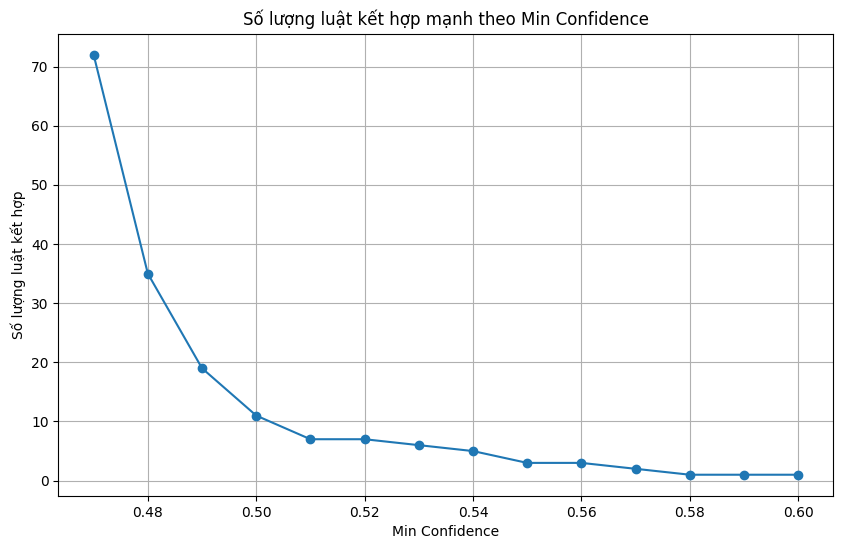

,Min Confidence,Số luật kết hợp mạnh
0,0.47,72
1,0.48,35
2,0.49,19
3,0.50,11
4,0.51,7
5,0.52,7
6,0.53,6
7,0.54,5
8,0.55,3
9,0.56,3


In [ ]:
min_conf_range = np.arange(0.47, 0.6001, 0.01)
num_rules_list = []

for min_conf in min_conf_range:
    filtered_rules_df = rules_df[np.isclose(rules_df['Confidence'], min_conf) | (rules_df['Confidence'] > min_conf)]
    num_rules_list.append(len(filtered_rules_df))

plt.figure(figsize=(10, 6))
plt.plot(min_conf_range, num_rules_list, marker='o', linestyle='-')
plt.xlabel('Min Confidence')
plt.ylabel('Số lượng luật kết hợp')
plt.title('Số lượng luật kết hợp mạnh theo Min Confidence')
plt.grid(True)
plt.show()

data = {'Min Confidence': min_conf_range, 'Số luật kết hợp mạnh': num_rules_list}
df_rules = pd.DataFrame(data)
df_rules

> Ở đây nhóm chọn ngưỡng min_conf = 0.50

In [ ]:
min_conf = 0.50
filtered_rules_df = rules_df[rules_df['Confidence'] >= min_conf]
filtered_rules_df.reset_index(drop=True, inplace=True)
filtered_rules_df

,Vế trái,Vế phải,Confidence,Support
0,"(Kidney Beans, Butter)",(Ice cream),0.544554,0.110110
1,"(Ice cream, Butter)",(Kidney Beans),0.531401,0.110110
2,"(Ice cream, Kidney Beans)",(Butter),0.561224,0.110110
3,"(Chocolate, Dill)",(Milk),0.572864,0.114114
4,"(Dill, Milk)",(Chocolate),0.600000,0.114114
5,"(Chocolate, Milk)",(Dill),0.540284,0.114114
6,(Bread),(Yogurt),0.502604,0.193193
7,(Dill),(Chocolate),0.500000,0.199199
8,(Ice cream),(Butter),0.504878,0.207207
9,(Milk),(Chocolate),0.520988,0.211211


# **4. Đánh giá luật kết hợp và luật kết hợp mạnh bằng độ đo LIFT**

In [ ]:
def calculate_lift(frequent_itemsets, rules, num_of_transactions):
    """
    Tính độ đo lift cho tất cả các luật kết hợp từ danh sách frequent_itemsets và rules.

    Parameters:
        - frequent_itemsets: List các tuple (frozenset itemset, support).
        - rules: List các tuple (frozenset(lhs), frozenset(rhs), confidence).

    Returns:
        - rules_with_lift: List các tuple (frozenset(lhs), frozenset(rhs), confidence, lift).
    """
    # Chuyển frequent_itemsets thành dictionary để dễ truy xuất support
    if frequent_itemsets[0][1] < 1: # Nếu frequent_itemsets là list các tuple: itemset, support
        support_dict = {itemset: support for itemset, support in frequent_itemsets}
    else: # Nếu frequent_itemsets là list các tuple: itemset, frequency
        support_dict = {itemset: freq/num_of_transactions for itemset, freq in frequent_itemsets}

    rules_with_lift = []
    for lhs, rhs, confidence, support in rules:
        # Tính lift = confidence / support(rhs)
        rhs_support = support_dict.get(rhs, 0)
        if rhs_support > 0:  # Đảm bảo không chia cho 0
            lift = confidence / rhs_support
            rules_with_lift.append((lhs, rhs, confidence, support, lift))

    return rules_with_lift

rules_with_lift = calculate_lift(frequent_itemsets, rules, len(transactions))

rules_with_lift_df = pd.DataFrame(rules_with_lift, columns=['Vế trái', 'Vế phải', 'Confidence', 'Support', 'Lift'])
rules_with_lift_df

,Vế trái,Vế phải,Confidence,Support,Lift
0,"(Kidney Beans, Butter)",(Ice cream),0.544554,0.110110,1.326853
1,"(Ice cream, Butter)",(Kidney Beans),0.531401,0.110110,1.301151
2,"(Ice cream, Kidney Beans)",(Butter),0.561224,0.110110,1.334913
3,"(Chocolate, Dill)",(Milk),0.572864,0.114114,1.413065
4,"(Dill, Milk)",(Chocolate),0.600000,0.114114,1.423753
...,...,...,...,...,...
241,(Kidney Beans),(Butter),0.495098,0.202202,1.177626
242,(Butter),(Ice cream),0.492857,0.207207,1.200889
243,(Ice cream),(Butter),0.504878,0.207207,1.200889
244,(Milk),(Chocolate),0.520988,0.211211,1.236263


In [ ]:
# lọc ra các rule có lift > 1
filtered_rules_lift = rules_with_lift_df[rules_with_lift_df['Lift'] > 1]
filtered_rules_lift

,Vế trái,Vế phải,Confidence,Support,Lift
0,"(Kidney Beans, Butter)",(Ice cream),0.544554,0.110110,1.326853
1,"(Ice cream, Butter)",(Kidney Beans),0.531401,0.110110,1.301151
2,"(Ice cream, Kidney Beans)",(Butter),0.561224,0.110110,1.334913
3,"(Chocolate, Dill)",(Milk),0.572864,0.114114,1.413065
4,"(Dill, Milk)",(Chocolate),0.600000,0.114114,1.423753
...,...,...,...,...,...
241,(Kidney Beans),(Butter),0.495098,0.202202,1.177626
242,(Butter),(Ice cream),0.492857,0.207207,1.200889
243,(Ice cream),(Butter),0.504878,0.207207,1.200889
244,(Milk),(Chocolate),0.520988,0.211211,1.236263


> Có 244/246 luật kết hợp có LIFT > 1

In [ ]:
# lọc ra các rule có lift > 1 và conffidence >= min_conf
filtered_rules_lift_1 = rules_with_lift_df[(rules_with_lift_df['Lift'] > 1) & (rules_with_lift_df['Confidence'] >= min_conf)]
filtered_rules_lift_1.reset_index(drop=True, inplace=True)
filtered_rules_lift_1

,Vế trái,Vế phải,Confidence,Support,Lift
0,"(Kidney Beans, Butter)",(Ice cream),0.544554,0.110110,1.326853
1,"(Ice cream, Butter)",(Kidney Beans),0.531401,0.110110,1.301151
2,"(Ice cream, Kidney Beans)",(Butter),0.561224,0.110110,1.334913
3,"(Chocolate, Dill)",(Milk),0.572864,0.114114,1.413065
4,"(Dill, Milk)",(Chocolate),0.600000,0.114114,1.423753
5,"(Chocolate, Milk)",(Dill),0.540284,0.114114,1.356141
6,(Bread),(Yogurt),0.502604,0.193193,1.195480
7,(Dill),(Chocolate),0.500000,0.199199,1.186461
8,(Ice cream),(Butter),0.504878,0.207207,1.200889
9,(Milk),(Chocolate),0.520988,0.211211,1.236263


> 11 luật kết hợp mạnh tìm được (min_sup = 0.11, min_conf = 0.5) đều có LIFT > 1
>
> 11 luật kết hợp mạnh đều đáng quan tâm
